# My-Fashion-MNIST-Experiments

In this notebook, I will design my own CNN architecture for classifying the Fashion-MNIST dataset, and will write functions such that I can experiment with different hyperparameters and loss functions/optimizers. LESHGOOOO

Note that just for loading the data in, I will use pre-existing code from [this tutorial](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html), which I also used in my `fashion-mnist.ipynb` notebook.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F 

from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [3]:
train_data = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [5]:
# experiment - play with the number of batches I want
# default is 4
batch_size = 5

In [6]:
# Create data loaders for our datasets; shuffle for training, not for test
training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(train_data)))
print('Testing set has {} instances'.format(len(test_data)))

Training set has 60000 instances
Testing set has 10000 instances


Dress  Dress  Dress  T-shirt/top  Sneaker


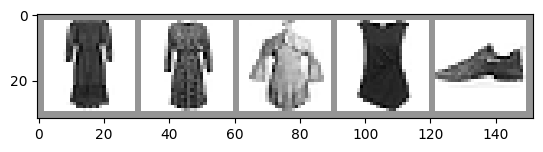

In [8]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(batch_size)))

In [9]:
len(train_data)

60000

In [10]:
train_sample, train_label = train_data[0]
train_sample.shape

torch.Size([1, 28, 28])

## Defining Model Architecture

Let's go for 3 convolutions, 4 fully-connected layers, options for activation (ReLU, sigmoid, tanh), and options for pooling (max, avg). This also gives me a great chance to 1. test out different model architectures, and 2. to test out the limits of my machine (MacBook Pro M3).

In [11]:
def cnn_dims(input_matrix_size, kernel_size):
    output_size_n = input_matrix_size - kernel_size + 1
    print(f'Input matrix size: {input_matrix_size}x{input_matrix_size}')
    print(f'Kernel size: {kernel_size}x{kernel_size}')
    print(f'Therefore output convolved matrix size: {output_size_n}x{output_size_n}')
    return output_size_n

def pooling_dims(input_matrix_size, kernel_size, stride):
    output_size_n = int(np.floor((input_matrix_size - kernel_size) / stride) + 1)
    print(f'Input matrix size: {input_matrix_size}x{input_matrix_size}')
    print(f'Kernel size: {kernel_size}x{kernel_size} + stride: {stride}')
    print(f'Therefore output pooled matrix size: {output_size_n}x{output_size_n}')
    return output_size_n

In [12]:
class MyFashionClassifier(nn.Module):

    def __init__(self, my_params):
        super(MyFashionClassifier, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=my_params['conv1_out_channels'],
            kernel_size=my_params['conv_kernel_size'],
            stride=my_params['conv_stride']
        )
        self.conv2 = nn.Conv2d(
            in_channels=my_params['conv1_out_channels'],
            out_channels=my_params['conv2_out_channels'],
            kernel_size=my_params['conv_kernel_size'],
            stride=my_params['conv_stride']
        )
        self.conv3 = nn.Conv2d(
            in_channels=my_params['conv2_out_channels'],
            out_channels=my_params['conv3_out_channels'],
            kernel_size=my_params['conv_kernel_size'],
            stride=my_params['conv_stride']
        )
        
        self.pool_type = my_params['pool_type']
        if self.pool_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=my_params['pool_kernel_size'], stride=my_params['pool_stride'])
        elif self.pool_type == 'avg':
            self.pool_type = nn.AvgPool2d(kernel_size=my_params['pool_kernel_size'], stride=my_params['pool_stride'])

        self.activation_type = my_params['activation_type']

        self.fc1 = nn.Linear(
            in_features=my_params['fc1_in_features'],
            out_features=my_params['fc1_out_features']
        )
        self.fc2 = nn.Linear(
            in_features=my_params['fc1_out_features'],
            out_features=my_params['fc2_out_features']
        )
        self.fc3 = nn.Linear(
            in_features=my_params['fc2_out_features'],
            out_features=my_params['fc3_out_features']
        )
        self.fc4 = nn.Linear(
            in_features=my_params['fc3_out_features'],
            out_features=10
        )

    def forward(self, x):
        # if self.pool_type == 'max':
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 128 * 2 * 2)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

### Instantiating Parameter Dictionary

First we start by getting an idea of how our dimensions look like between layers. We will then use this to fill our parameters dict.

In [13]:
conv_kernel_size = 2
pool_kernel_size = 2
pool_stride = 2

print("First convolutional block")
conv1_output = cnn_dims(28, conv_kernel_size)
print("")
pool1_output = pooling_dims(conv1_output, pool_kernel_size, pool_stride)
print("------")
print("Second convolutional block")
conv2_output = cnn_dims(pool1_output, conv_kernel_size)
print("")
pool2_output = pooling_dims(conv2_output, pool_kernel_size, pool_stride)
print("------")
print("Third convolutional block")
conv3_output = cnn_dims(pool2_output, conv_kernel_size)
print("")
pool3_output = pooling_dims(conv3_output, pool_kernel_size, pool_stride)

First convolutional block
Input matrix size: 28x28
Kernel size: 2x2
Therefore output convolved matrix size: 27x27

Input matrix size: 27x27
Kernel size: 2x2 + stride: 2
Therefore output pooled matrix size: 13x13
------
Second convolutional block
Input matrix size: 13x13
Kernel size: 2x2
Therefore output convolved matrix size: 12x12

Input matrix size: 12x12
Kernel size: 2x2 + stride: 2
Therefore output pooled matrix size: 6x6
------
Third convolutional block
Input matrix size: 6x6
Kernel size: 2x2
Therefore output convolved matrix size: 5x5

Input matrix size: 5x5
Kernel size: 2x2 + stride: 2
Therefore output pooled matrix size: 2x2


In [14]:
my_params = {
    # number of output channels for each convolution
    # good rule of thumb is to double every time
    'conv1_out_channels':32,
    'conv2_out_channels':64,
    'conv3_out_channels':128,
    # number of fully-connected layers - max 4
    'fc1_in_features':128 * 2 * 2, # x * y * y, where x=conv3_out_channels and y=dim(conv3_out_channels)
    'fc1_out_features':256, # perhaps we can halve every time now?
    'fc2_out_features':128,
    'fc3_out_features':64,
    # kernel size - same for all convolutions and for all poolings
    'conv_kernel_size':2,
    'pool_kernel_size':2,
    # stride - same for all convolutions and for all poolings
    'conv_stride':1,
    'pool_stride':2,
    # desired pooling type - either of {'max', 'avg'}
    'pool_type': 'max',
    # desired activation - either of {'relu', 'sigmoid', 'tanh'}
    'activation_type': 'relu',
    # optimizer - either of {'sgd', 'adam'}
    'optimizer':'sgd'
}

# instantiating the model
fashion_classifier_model = MyFashionClassifier(my_params)

In [15]:
fashion_classifier_model

MyFashionClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

### Defining Loss Function + Optimizer

In [16]:
loss_fn = torch.nn.CrossEntropyLoss() 

In [17]:
def choose_optimizer(model, optimizer_choice, learning_rate, momentum=None):
    # function to choose optimizer
    if optimizer_choice == 'sgd': 
        optimizer = torch.optim.SGD(
            params=model.parameters(), 
            lr=learning_rate, 
            momentum=momentum
            ) 
    elif optimizer_choice=='adam': 
        optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    return optimizer

my_optimizer = choose_optimizer(
    model=fashion_classifier_model, 
    optimizer_choice=my_params['optimizer'], 
    learning_rate=0.001,
    momentum=0.9
    )

In [72]:
def plot_loss_accuracy_curves(losses, accuracies, epoch_num):
    # plotting loss vs epoch
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title(f'Epoch {epoch_num}: Loss Curve')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    # plotting accuracy vs epoch
    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.title(f'Epoch {epoch_num}: Accuracy Curve (avg={np.round(np.mean(accuracies),2)}%)')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    plt.show()

### Model Training

In [62]:
# # Inspect one batch of data
# for i, (inputs, labels) in enumerate(training_loader):
#     print(f"Batch {i+1}:")
#     # print("Inputs:")
#     # print(type(inputs))
#     # print("Labels:")
#     # print(labels)
#     # print(type(labels))
#     outputs = fashion_classifier_model(inputs)
#     print(type(outputs))
#     # print(outputs)
#     loss = loss_fn(outputs, labels)
#     print(type(loss))
#     loss.backward()
#     my_optimizer.step()
#     # print(outputs)
#     predicted = torch.argmax(outputs, 1) #argmax
#     print(predicted)
#     print((predicted == labels).sum().item())

#     break  # Break after inspecting the first batch

Batch 1:
<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([9, 2, 5, 9, 1])
4


In [73]:
def train_model(
        model, params, optimizer, loss_fn, training_loader, num_epochs=10
        ):
    
    losses = []
    accuracies = []

    # iterating over number of epochs
    for epoch in range(num_epochs):
        current_loss = 0
        total_correct = 0
        total_samples = 0

        model.train()

        for i, (inputs, labels) in enumerate(training_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            current_loss = loss.item()
            

            predicted = torch.argmax(outputs, 1)
            total_correct += (predicted == labels).sum().item() # look into settubg them as long integers
            total_samples += labels.size(0)

            if i % 100 == 0:

                last_loss = current_loss / 100
                losses.append(last_loss)

                accuracy = 100 * total_correct / total_samples
                accuracies.append(accuracy)

                print(f'Epoch [{epoch+1}/{num_epochs}], Batch {i+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

                current_loss = 0
                total_correct = 0
                total_samples = 0
                
        plot_loss_accuracy_curves(losses, accuracies, 1)

    return losses, accuracies

In [74]:
losses, accuracies = train_model(
    model=fashion_classifier_model, 
    params=my_params, 
    optimizer=my_optimizer, 
    loss_fn=loss_fn, 
    training_loader=training_loader,
    num_epochs=1
    )

Epoch [1/1], Batch 1, Loss: 1.5489, Accuracy: 60.0000
Epoch [1/1], Batch 101, Loss: 0.0167, Accuracy: 93.2000
Epoch [1/1], Batch 201, Loss: 0.0962, Accuracy: 93.2000
Epoch [1/1], Batch 301, Loss: 1.5378, Accuracy: 90.6000
Epoch [1/1], Batch 401, Loss: 0.1870, Accuracy: 90.4000
Epoch [1/1], Batch 501, Loss: 0.0559, Accuracy: 91.8000
Epoch [1/1], Batch 601, Loss: 0.0360, Accuracy: 92.4000
Epoch [1/1], Batch 701, Loss: 0.0480, Accuracy: 91.8000
Epoch [1/1], Batch 801, Loss: 0.0253, Accuracy: 90.2000
Epoch [1/1], Batch 901, Loss: 0.0754, Accuracy: 92.8000
Epoch [1/1], Batch 1001, Loss: 0.5239, Accuracy: 91.0000
Epoch [1/1], Batch 1101, Loss: 0.1199, Accuracy: 89.6000
Epoch [1/1], Batch 1201, Loss: 0.4211, Accuracy: 90.8000
Epoch [1/1], Batch 1301, Loss: 0.0323, Accuracy: 91.4000
Epoch [1/1], Batch 1401, Loss: 0.2708, Accuracy: 91.2000
Epoch [1/1], Batch 1501, Loss: 0.5253, Accuracy: 91.2000
Epoch [1/1], Batch 1601, Loss: 0.3808, Accuracy: 90.6000
Epoch [1/1], Batch 1701, Loss: 0.0066, Accu

In [67]:
np.mean(accuracies)

np.float64(88.18333333333334)

In [22]:
# def train_epoch(model, params, optimizer, loss_fn, train_loader, epoch_index, loss_list, accuracy_list):
#     model.train()
#     running_loss = 0
#     total_correct = 0
#     total_samples = 0

#     for i, (inputs, labels) in enumerate(train_loader):
#         optimizer.zero_grad()
#         outputs = fashion_classifier_model(inputs)
#         loss = loss_fn(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         _, predicted = torch.max(outputs, 1)
#         total_correct += (predicted == labels).sum().item()
#         total_samples += labels.size(0)

#         if i % 1000 == 999:
#             last_loss = running_loss / 1000
#             loss_list.append(last_loss)

#             accuracy = 100 * total_correct / total_samples
#             accuracy_list.append(accuracy)

#             print(running_loss, len(train_loader), total_correct, total_samples)

#             print(f"Epoch {epoch_index+1}, Batch {i+1}, Loss: {last_loss:.4f}, Accuracy: {accuracy:.2f}%")
#             running_loss = 0
#             total_correct = 0
#             total_samples = 0
            
#     return running_loss / len(train_loader), 100.0 * total_correct / total_samples


In [23]:
# train_epoch(
#     model=fashion_classifier_model, 
#     params=my_params, 
#     optimizer=my_optimizer, 
#     loss_fn=loss_fn, 
#     train_loader=training_loader, 
#     epoch_index=0, 
#     loss_list=[], 
#     accuracy_list=[]
#     )

423.5049269270967 12000 4211 5000
Epoch 1, Batch 1000, Loss: 0.4235, Accuracy: 84.22%
404.5518905025092 12000 4235 5000
Epoch 1, Batch 2000, Loss: 0.4046, Accuracy: 84.70%
410.7615852156596 12000 4252 5000
Epoch 1, Batch 3000, Loss: 0.4108, Accuracy: 85.04%
417.22262729442446 12000 4215 5000
Epoch 1, Batch 4000, Loss: 0.4172, Accuracy: 84.30%
402.0472679180093 12000 4261 5000
Epoch 1, Batch 5000, Loss: 0.4020, Accuracy: 85.22%
396.30894401686965 12000 4275 5000
Epoch 1, Batch 6000, Loss: 0.3963, Accuracy: 85.50%
389.9798663900583 12000 4278 5000
Epoch 1, Batch 7000, Loss: 0.3900, Accuracy: 85.56%
385.46019611140946 12000 4266 5000
Epoch 1, Batch 8000, Loss: 0.3855, Accuracy: 85.32%
383.9879690274829 12000 4290 5000
Epoch 1, Batch 9000, Loss: 0.3840, Accuracy: 85.80%
362.3597458624863 12000 4299 5000
Epoch 1, Batch 10000, Loss: 0.3624, Accuracy: 85.98%
365.5963642257266 12000 4315 5000
Epoch 1, Batch 11000, Loss: 0.3656, Accuracy: 86.30%
377.491388071212 12000 4313 5000
Epoch 1, Batch 1

ZeroDivisionError: float division by zero